<a href="https://colab.research.google.com/github/Aliyahk888/GAN-based-Image-Restoration-and-Colourization/blob/main/Colorization_with_SRGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!unzip /content/drive/MyDrive/Image_data/dataset.zip

Archive:  /content/drive/MyDrive/Image_data/dataset.zip
  inflating: data/24322.jpg          
  inflating: data/24315.jpg          
  inflating: data/24321.jpg          
  inflating: data/24269.jpg          
  inflating: data/24301.jpg          
  inflating: data/24294.jpg          
  inflating: data/24304.jpg          
  inflating: data/24334.jpg          
  inflating: data/24329.jpg          
  inflating: data/24300.jpg          
  inflating: data/24325.jpg          
  inflating: data/24324.jpg          
  inflating: data/24319.jpg          
  inflating: data/24317.jpg          
  inflating: data/24328.jpg          
  inflating: data/24309.jpg          
  inflating: data/24297.jpg          
  inflating: data/24290.jpg          
  inflating: data/24332.jpg          
  inflating: data/24310.jpg          
  inflating: data/24323.jpg          
  inflating: data/24279.jpg          
  inflating: data/24282.jpg          
  inflating: data/24265.jpg          
  inflating: data/24264.jpg     

In [10]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from matplotlib import image
from matplotlib import pyplot as plt
import os
from tensorflow import keras
import argparse
import cv2

In [11]:
dataset_split = 2500

master_dir = 'data'
lr_list = []
hr_list = []
for image_file in os.listdir( master_dir )[ 0 : dataset_split ]:
    hr = Image.open( os.path.join( master_dir , image_file ) ).resize( ( 128 , 128 ) )
    hr=np.asarray(hr)
    #hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
    #lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
    lr= Image.open( os.path.join( master_dir , image_file ) ).resize( ( 32 , 32 ) ) 
    lr = lr.convert( 'L' )
    lr=np.asarray(lr)
    hr_list.append(hr)
    lr_list.append(lr)

lr_list = np.array(lr_list)
hr_list = np.array(hr_list)


In [12]:

#########################################################################

#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)




In [13]:

from keras.applications.vgg19 import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [14]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [17]:

lr_images=lr_list
hr_images=hr_list


#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)

lr_train = np.repeat(lr_train[..., np.newaxis], 3, -1)
print(lr_train.shape)
lr_test = np.repeat(lr_test[..., np.newaxis], 3, -1)


hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)


(1675, 32, 32, 3)


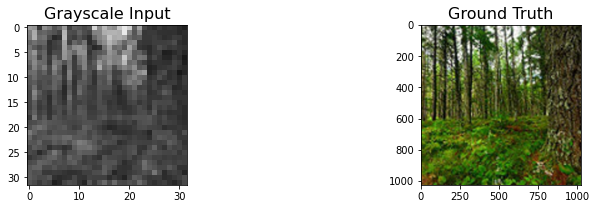

In [19]:
plt.figure(figsize=(10,10))
or_image = plt.subplot(3,3,1)
or_image.set_title('Grayscale Input', fontsize=16)
plt.imshow(lr_test[0] , cmap='gray' )

ou_image = plt.subplot(3,3,3)
image = Image.fromarray( ( hr_test[0] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
ou_image.set_title('Ground Truth', fontsize=16)
plt.imshow( image )

In [20]:

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [21]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

In [ ]:
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    
epochs = 20
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size,1)) 
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] 
        hr_imgs = train_hr_batches[b] 
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        

        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
  
        discriminator.trainable = False
        

        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
  
        image_features = vgg.predict(hr_imgs)
     

        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        

        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
   
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    

    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: 

        generator.save("gen_e_"+ str(e+1) +".h5")


100%|██████████| 1675/1675 [04:28<00:00,  6.24it/s]


epoch: 1 g_loss: 61.48542148106134 d_loss: [1.59050258 0.81134328]


100%|██████████| 1675/1675 [04:10<00:00,  6.70it/s]


epoch: 2 g_loss: 40.97348472282068 d_loss: [0.60191792 0.93343284]


100%|██████████| 1675/1675 [04:09<00:00,  6.73it/s]


epoch: 3 g_loss: 35.48091013495602 d_loss: [0.3546613 0.9680597]


100%|██████████| 1675/1675 [04:08<00:00,  6.74it/s]


epoch: 4 g_loss: 33.233756203580256 d_loss: [0.18082613 0.99313433]


100%|██████████| 1675/1675 [04:11<00:00,  6.65it/s]


epoch: 5 g_loss: 31.382869389306254 d_loss: [0.23476001 0.98477612]


100%|██████████| 1675/1675 [04:09<00:00,  6.72it/s]


epoch: 6 g_loss: 30.157761690225175 d_loss: [0.26373604 0.98656716]


100%|██████████| 1675/1675 [04:09<00:00,  6.73it/s]


epoch: 7 g_loss: 28.30356495273647 d_loss: [0.23088229 0.98686567]


100%|██████████| 1675/1675 [04:09<00:00,  6.71it/s]


epoch: 8 g_loss: 27.070829567126374 d_loss: [0.09557201 0.98925373]


100%|██████████| 1675/1675 [04:10<00:00,  6.69it/s]


epoch: 9 g_loss: 25.63802542729164 d_loss: [0.07576281 0.98925373]


100%|██████████| 1675/1675 [04:14<00:00,  6.59it/s]

epoch: 10 g_loss: 24.721623279301088 d_loss: [0.04207914 0.99402985]



100%|██████████| 1675/1675 [04:09<00:00,  6.72it/s]


epoch: 11 g_loss: 23.650548980271637 d_loss: [0.05074417 0.99343284]


100%|██████████| 1675/1675 [04:09<00:00,  6.70it/s]


epoch: 12 g_loss: 22.71167043493755 d_loss: [0.03370779 0.99641791]


100%|██████████| 1675/1675 [04:09<00:00,  6.70it/s]


epoch: 13 g_loss: 21.8050328075352 d_loss: [0.06062931 0.99492537]


100%|██████████| 1675/1675 [04:09<00:00,  6.71it/s]


epoch: 14 g_loss: 21.11172160540054 d_loss: [0.05014015 0.9958209 ]


100%|██████████| 1675/1675 [04:10<00:00,  6.68it/s]


epoch: 15 g_loss: 19.930405292297475 d_loss: [0.0309932  0.99761194]


100%|██████████| 1675/1675 [04:12<00:00,  6.63it/s]


epoch: 16 g_loss: 19.25822000773985 d_loss: [0.04801047 0.99522388]


100%|██████████| 1675/1675 [04:09<00:00,  6.72it/s]


epoch: 17 g_loss: 18.62677727371899 d_loss: [0.03475496 0.99641791]


100%|██████████| 1675/1675 [04:08<00:00,  6.74it/s]


epoch: 18 g_loss: 17.96053944737164 d_loss: [0.04610232 0.99641791]


100%|██████████| 1675/1675 [04:07<00:00,  6.78it/s]


epoch: 19 g_loss: 17.739448535620276 d_loss: [0.03607332 0.99761194]


100%|██████████| 1675/1675 [04:04<00:00,  6.85it/s]

epoch: 20 g_loss: 16.9960019888095 d_loss: [0.0492068  0.99522388]


In [23]:
from numpy import loadtxt
from tensorflow.keras.models import load_model
generator = load_model("/content/drive/MyDrive/srganmodel20.h5")

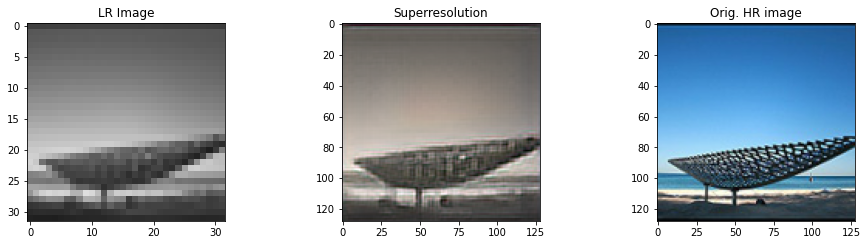

In [24]:

from keras.models import load_model
from numpy.random import randint



[X1, X2] = [lr_test, hr_test]


ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]


gen_image = generator.predict(src_image)



# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()




In [ ]:
generator.save("/content/drive/MyDrive/srganmodel20.h5")

FUNCTION TO TAKE CUSTOM INPUT

In [ ]:
def preprocess():
  lr_list = []
  hr_list = []

  hr= Image.open('/content/scenery.jpeg').resize( ( 128 , 128 ) )
  hr=np.asarray(img)

  lr= Image.open('/content/scenery.jpeg').resize( ( 32 , 32 ) ) 
  lr = lr.convert( 'L' )

  lr=np.asarray(lr)
  hr_list.append(hr)
  lr_list.append(lr)

  lr_list = np.array(lr_list)
  hr_list = np.array(hr_list)
